# Constructing discretized tanh that allows int8 inference in Pytorch

In [1]:
import torch
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

The main idea is:

    Now: float -> tanh -> float
    Intended: float -> qint -> qint tanh -> qint -> float

Did some reading, and sketched out the expected steps by dividing this notebook into subsections.

### 1. Implement the Baluja et al 2018 logic for obtaining quantized output

In [3]:
# This is  modified from: https://bisonai.com/2019/03/14/nmnf/#activation-quantization
class tanhD(torch.autograd.Function):
    gamma_min = -1.0
    gamma_max = 1.0

    @staticmethod
    def forward(ctx, input: torch.autograd.Variable, levels: int):
        y = torch.nn.tanh(input)
        ctx.y = y

        step = (self.gamma_max - self.gamma_min)/(levels - 1)
        quant_y = torch.floor((y - self.gamma_min)/step + 0.5) * step + self.gamma_min
        return quant_y

    @staticmethod
    def backward(self, quant_y: torch.autograd.Variable):
        grad_input = 1.0 - ctx.y**2
        grad_levels = None
        return grad_input, grad_levels

Here's a simpler numpy version to work with:

In [4]:
def tanhd(x, levels: int):
    gamma_min = -1
    gamma_max = 1
    y = np.tanh(x)
    
    step = (gamma_max - gamma_min)/(levels - 1)
    quant_y = np.floor((y - gamma_min)/step + 0.5) * step + gamma_min
    
    return quant_y

In [5]:
x = np.linspace(-8, 8, num=100)
y = tanhd(x, levels=4)

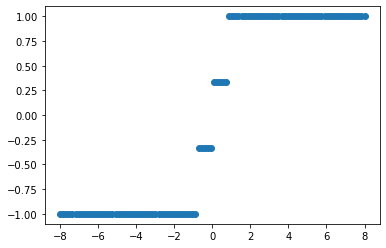

In [6]:
plt.scatter(x, y)

### 2. Extend it to extract the boundaries of quantized weights

The boundaries of the quantized weights can be further derived from the formula. The floor function keeps everything quantized, and everytime the arguments to the floor function turn up to be integers, that is the beginning of the next plateau.

(y - gamma_min)/step + 0.5 = 0 is the entrypoint of the first plateau.

y - gamma_min = -0.5 * step

y = gamma_min - 0.5 * step

if set that to 1:

y - gamma_min = 0.5 * step

y = gamma_min + 0.5 * step

if set that to 2:

y = gamma_min + 1.5 * step

Both `pytorch` and `numpy` have inverse `tanh`. Turns out Pytorch has it due to feature request to have parity with numpy and also for working in hyperbolic space.

In [9]:
def find_boundaries(levels: int):
    gamma_min = -1
    gamma_max = 1
    
    assert levels >= 2
    
    step = (gamma_max - gamma_min)/(levels - 1)
    
    # This defines the output values of the steps
    outputs = [gamma_min + i * step for i in range(levels)]
    
    # This finds the dividing points between the steps
    # 4 outputs means 3 dividing points
    # So if x is less than the first dividing x, take the value of the first dividing y!
    dividing_ys = [(outputs[i] + outputs[i+1])/2 for i in range(len(outputs)-1)]
    
    # Find the corresponding arctanh(y) = x for each dividing y
    dividing_xs = np.arctanh(dividing_ys)
    
    """
    # Find the min value required to trigger the right most step
    min_right_y = gamma_min + (levels-1-0.5) * step
    min_right_x = np.arctanh(min_right_y)
    
    xs = []
    ys = []
    
    # For quantized outputs 0 to levels-2
    # Find the max value that will still fit on the plateau
    for i in range(0, levels-1):
        y_right = gamma_min + (i+1-0.5) * step
        
        # Find x = arctanh(y)
        x_right = np.arctanh(y_right)
        
        xs.append(x_right)
    """
    
    def tanh_int(x):
        # So if x is less than the first dividing x, take the value of the first dividing y!
        for i in range(levels-1):
            if x <= dividing_xs[i]:
                return dividing_ys[i] - 0.5 * step
        else:
            return dividing_ys[i] + 0.5 * step
        """
        # Check if belongs in right-most step
        if x >= min_right_y:
            return outputs[-1]
        else:
            # Else check if belong in previous steps
            for i in range(levels-1):
                if x < xs[i]:
                    return outputs[i]
        """
        
    return tanh_int

This should achieve similar feature parity as the `tanhd` function above.

In [10]:
x = np.linspace(-8, 8, num=100)
y = tanhd(x, levels=4)

In [11]:
tanh_int = find_boundaries(levels=4)

In [12]:
y2 = []
for i in x:
    # print(f"x: {i}, y: {tanh_int(i)}")
    y2.append(tanh_int(i))
y2 = np.array(y2)

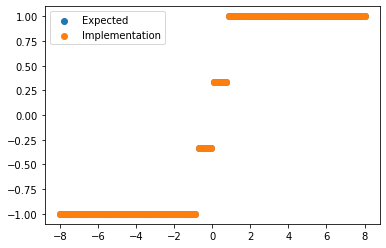

In [13]:
plt.scatter(x, y, label="Expected")
plt.scatter(x, y2, label="Implementation")
plt.legend()

In [14]:
y.dtype, y2.dtype

(dtype('float64'), dtype('float64'))

In [15]:
np.isclose(y, y2).any()

True

Good!

In [16]:
x = np.linspace(-8, 8, num=100)
y = tanhd(x, levels=256)

In [17]:
tanh_int = find_boundaries(levels=256)

In [18]:
y2 = []
for i in x:
    # print(f"x: {i}, y: {tanh_int(i)}")
    y2.append(tanh_int(i))
y2 = np.array(y2)

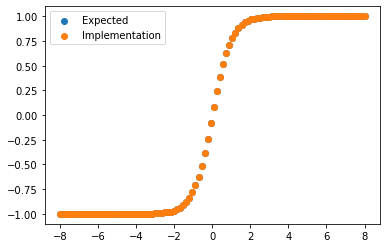

In [19]:
plt.scatter(x, y, label="Expected")
plt.scatter(x, y2, label="Implementation")
plt.legend()

In [20]:
np.isclose(y, y2).any()

True

Verified this implementation to be equivalent to the one in Baluja et al 2018. Ended up now w/ a version of tanh that takes float input and outputs quantized output, while skipped the computation of tanh itself.

### 3. Build tanh mapping in int8 and test that the implementation is sane

Still need to get the function to work on using int8 input, and also int8 output. This is where I need to leave numpy behind and work in torch to use the qint dtypes.

Wonder what is the sensitivity limit for tanh.

In [21]:
np.arctanh([-1+1e-5, -1+1e-4, -1+1e-3, -1+1e-2, -1+1e-1])

array([-6.10303382, -4.95171878, -3.80020117, -2.64665241, -1.47221949])

For the output of tanh(x) to change from -1 to -0.99, x needs to move from -inf to -2.7. We don't need a lot of precision here.

In [22]:
qx = torch.quantize_per_tensor(torch.Tensor(x), scale=0.025, zero_point=0, dtype=torch.qint8)

In [23]:
qx

tensor([-3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.1500, -3.0000,
        -2.8250, -2.6750, -2.5000, -2.3500, -2.1750, -2.0250, -1.8500, -1.7000,
        -1.5250, -1.3750, -1.2000, -1.0500, -0.9000, -0.7250, -0.5750, -0.4000,
        -0.2500, -0.0750,  0.0750,  0.2500,  0.4000,  0.5750,  0.7250,  0.9000,
         1.0500,  1.2000,  1.3750,  1.5250,  1.7000,  1.8500,  2.0250,  2.1750,
         2.3500,  2.5000,  2.6750,  2.8250,  3.0000,  3.1500,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.17

In [24]:
qy = []
for i in qx:
    qy.append(tanh_int(i))
qy = np.array(qy)

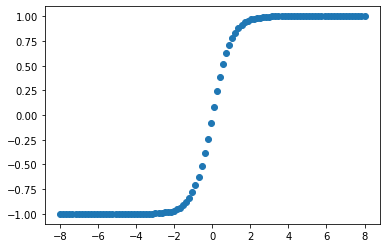

In [25]:
plt.scatter(x, y)

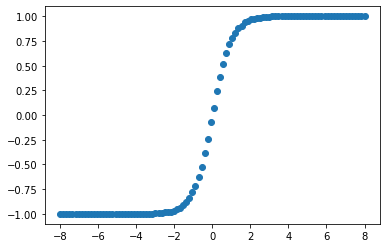

In [26]:
plt.scatter(x, qy)

Looks good enough to me, and verified drop-in compatibility with qint input. Now for the output.

In [27]:
def find_boundaries(levels: int, scale: float = 0.025, zero_point: float = 0):
    gamma_min = -1
    gamma_max = 1
    
    assert levels >= 2
    
    step = (gamma_max - gamma_min)/(levels - 1)
    
    # This defines the output values of the steps
    outputs = [gamma_min + i * step for i in range(levels)]
    
    # Add quantization
    torch_outputs = torch.Tensor(outputs)
    q_outputs = torch.quantize_per_tensor(torch_outputs, scale=scale, zero_point=zero_point, dtype=torch.qint8)
    q_int_outputs = q_outputs.int_repr()
    floated_q_outputs = torch.dequantize(q_outputs)
    
    # Use the quantized outputs, in case that quantization shifted the outputs from the original floating point too far
    
    # This finds the dividing points between the steps
    # 4 outputs means 3 dividing points
    # So if x is less than the first dividing x, take the value of the first dividing y!
    dividing_ys = [(floated_q_outputs[i] + floated_q_outputs[i+1])/2 for i in range(len(outputs)-1)]
    
    # Find the corresponding arctanh(y) = x for each dividing y
    dividing_xs = np.arctanh(dividing_ys)
    
    def _tanh_int(x):
        # This needs to work on the underlying int representation! 
        # Assumes input is qint, outputs qint
        # qint8 does not support zeros_like, or torch.stack! 
        # Need to be a bit creative here
        
        # So if x is less than the first dividing x, return the value of the first output level
        for i in range(levels-1):
            if x <= dividing_xs[i]:
                return q_outputs[i]
        else:
            return q_outputs[-1]
        
    def tanh_int(x):
        if isinstance(x, torch.Tensor):
            # ys = []
            # for i in x:
            #     ys.append(_tanh_int(i))
            # ys = torch.tensor(ys, dtype=torch.int8)
            # return ys
            
            # Finally found one method that works
            ys = torch.zeros(size=x.size())
            ys = torch.quantize_per_tensor(ys, scale=scale, zero_point=zero_point, dtype=torch.qint8)
            for count, i in enumerate(x):
                ys[count] = _tanh_int(i)
            return ys
        
        else:
            return _tanh_int(x)

    return tanh_int, q_outputs

In [28]:
x = np.linspace(-8, 8, num=100)
y = tanhd(x, levels=256)

In [29]:
tanh_int, q_outputs = find_boundaries(levels=256)

<ipython-input-27-65b1227bbb06>:26: RuntimeWarning: divide by zero encountered in arctanh
  dividing_xs = np.arctanh(dividing_ys)


In [30]:
q_outputs

tensor([-1.0000, -1.0000, -0.9750, -0.9750, -0.9750, -0.9500, -0.9500, -0.9500,
        -0.9250, -0.9250, -0.9250, -0.9250, -0.9000, -0.9000, -0.9000, -0.8750,
        -0.8750, -0.8750, -0.8500, -0.8500, -0.8500, -0.8250, -0.8250, -0.8250,
        -0.8000, -0.8000, -0.8000, -0.8000, -0.7750, -0.7750, -0.7750, -0.7500,
        -0.7500, -0.7500, -0.7250, -0.7250, -0.7250, -0.7000, -0.7000, -0.7000,
        -0.6750, -0.6750, -0.6750, -0.6750, -0.6500, -0.6500, -0.6500, -0.6250,
        -0.6250, -0.6250, -0.6000, -0.6000, -0.6000, -0.5750, -0.5750, -0.5750,
        -0.5500, -0.5500, -0.5500, -0.5250, -0.5250, -0.5250, -0.5250, -0.5000,
        -0.5000, -0.5000, -0.4750, -0.4750, -0.4750, -0.4500, -0.4500, -0.4500,
        -0.4250, -0.4250, -0.4250, -0.4000, -0.4000, -0.4000, -0.4000, -0.3750,
        -0.3750, -0.3750, -0.3500, -0.3500, -0.3500, -0.3250, -0.3250, -0.3250,
        -0.3000, -0.3000, -0.3000, -0.2750, -0.2750, -0.2750, -0.2750, -0.2500,
        -0.2500, -0.2500, -0.2250, -0.22

In [31]:
q_outputs[0]

tensor(-1., size=(), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.025, zero_point=0)

In [32]:
qx = torch.quantize_per_tensor(torch.Tensor(x), scale=0.025, zero_point=0, dtype=torch.qint8)

In [33]:
torch.qint8

torch.qint8

In [34]:
qx

tensor([-3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.1500, -3.0000,
        -2.8250, -2.6750, -2.5000, -2.3500, -2.1750, -2.0250, -1.8500, -1.7000,
        -1.5250, -1.3750, -1.2000, -1.0500, -0.9000, -0.7250, -0.5750, -0.4000,
        -0.2500, -0.0750,  0.0750,  0.2500,  0.4000,  0.5750,  0.7250,  0.9000,
         1.0500,  1.2000,  1.3750,  1.5250,  1.7000,  1.8500,  2.0250,  2.1750,
         2.3500,  2.5000,  2.6750,  2.8250,  3.0000,  3.1500,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.17

In [35]:
qy = tanh_int(qx)

In [36]:
qy

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.9750, -0.9750, -0.9750, -0.9750, -0.9500, -0.9250,
        -0.9000, -0.8750, -0.8250, -0.7750, -0.7250, -0.6250, -0.5250, -0.3750,
        -0.2500, -0.0750,  0.0750,  0.2500,  0.3750,  0.5250,  0.6250,  0.7250,
         0.7750,  0.8250,  0.8750,  0.9000,  0.9250,  0.9500,  0.9750,  0.9750,
         0.9750,  0.9750,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.00

In [37]:
qy

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.9750, -0.9750, -0.9750, -0.9750, -0.9500, -0.9250,
        -0.9000, -0.8750, -0.8250, -0.7750, -0.7250, -0.6250, -0.5250, -0.3750,
        -0.2500, -0.0750,  0.0750,  0.2500,  0.3750,  0.5250,  0.6250,  0.7250,
         0.7750,  0.8250,  0.8750,  0.9000,  0.9250,  0.9500,  0.9750,  0.9750,
         0.9750,  0.9750,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.00

Initially, I only managed to produce the int representation of the output. From looking at the source code for `torch.nn.quantized.Quantize`, seemed out of reach to implement converting int8 to qint8. I can return slices of qint8 Tensors, but initializing them is not allowed, nor is concatenating them. Ended up converting a tensor of zeros with the right shape to qint8, and replaced each element one by one. Hacky but gives me an output in qint8 that plays well w/ Pytorch quantization.

### 4. Implement as a `torch.autograd.Function` layer that can be used

Ref: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

While I am only interested in the forward loop, also implemented the backward loop from Baluja et al 2018 while I'm at it.

In [40]:
class Qtanh(torch.autograd.Function):

    def __init__(self, levels: int, scale: float = 0.025, zero_point: float = 0):
        super().__init__()
        self.tanh_int = self.create_tanh_int(levels=levels, scale=scale, zero_point=zero_point)
    
    def create_tanh_int(self, levels: int, scale: float, zero_point: float):
        gamma_min = -1
        gamma_max = 1

        assert levels >= 2

        step = (gamma_max - gamma_min)/(levels - 1)

        # This defines the output values of the steps
        outputs = [gamma_min + i * step for i in range(levels)]

        # Add quantization
        torch_outputs = torch.tensor(outputs)
        q_outputs = torch.quantize_per_tensor(torch_outputs, scale=scale, zero_point=zero_point, dtype=torch.qint8)

        # Use the quantized outputs, in case that quantization shifted the outputs from the original floating point too far
        floated_q_outputs = torch.dequantize(q_outputs)
        dividing_ys = [(floated_q_outputs[i] + floated_q_outputs[i+1])/2 for i in range(len(outputs)-1)]

        # Find the corresponding arctanh(y) = x for each dividing y
        dividing_xs = torch.atanh(torch.tensor(dividing_ys))

        def _tanh_int(x):
            for i in range(levels-1):
                if x <= dividing_xs[i]:
                    return q_outputs[i]
            else:
                return q_outputs[-1]

        def tanh_int(x):
            if isinstance(x, torch.Tensor):
                # Finally found one method that works
                ys = torch.zeros(size=x.size())
                ys = torch.quantize_per_tensor(ys, scale=scale, zero_point=zero_point, dtype=torch.qint8)
                for count, i in enumerate(x):
                    ys[count] = _tanh_int(i)
                return ys

            else:
                return _tanh_int(x)

        return tanh_int

    @staticmethod
    def forward(ctx, x: torch.autograd.Variable):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(x)
        return tanh_int(x)

    @staticmethod
    def backward(ctx):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        x, = ctx.saved_tensors
        grad_input = 1.0 - torch.tanh(x) ** 2
        grad_levels = None
        return grad_input, grad_levels

In [41]:
qtanh = Qtanh(levels=256, scale=0.025, zero_point=0)

In [44]:
qtanh.apply(qx)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.9750, -0.9750, -0.9750, -0.9750, -0.9500, -0.9250,
        -0.9000, -0.8750, -0.8250, -0.7750, -0.7250, -0.6250, -0.5250, -0.3750,
        -0.2500, -0.0750,  0.0750,  0.2500,  0.3750,  0.5250,  0.6250,  0.7250,
         0.7750,  0.8250,  0.8750,  0.9000,  0.9250,  0.9500,  0.9750,  0.9750,
         0.9750,  0.9750,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.00

### 5. Define a model that utilizes the tanh layer and works properly

In [45]:
# TODO: Pending quantized model

### 6. Combine w/ a model that uses int8 and let the layers fly